In [164]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np 
import random
random.seed(1)

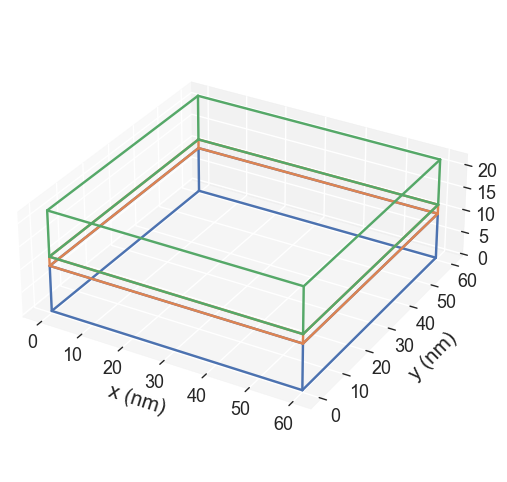

In [165]:
p1 = (0, 0, 0)
p2 = (60e-9, 60e-9, 22e-9)
region = df.Region(p1=p1, p2=p2)
subregions = {"r1": df.Region(p1=(0, 0, 0), p2=(60e-9, 60e-9, 10e-9)), "spacer": df.Region(p1=(0, 0, 10e-9), p2=(60e-9, 60e-9, 12e-9), bc="d"), "r2": df.Region(p1=(0, 0, 12e-9), p2=(60e-9, 60e-9, 22e-9))}
mesh = df.Mesh(region=region, n=(60, 60, 22), subregions=subregions)
mesh.mpl.subregions()

In [166]:
import numbers

class idmi(mm.EnergyTerm):
    _reprlatex = r"$-D \cdot (\mathbf{m}_1 \times \mathbf{m}_2)$"
    _allowed_attributes = ["D", "m1", "m2"]

    def effective_field(self, D, m1, m2):
        H_eff_m1 = df.Field(m1.mesh, nvdim=3, value=np.cross(self.D, m2.array))

        # For m2: H_eff_m2 = -D x m1
        H_eff_m2 = df.Field(m2.mesh, nvdim=3, value=-np.cross(self.D, m1.array))

        return H_eff_m1, H_eff_m2

    def _script(self):
        mif = ""
        if isinstance(self.D, numbers.Real):
            mif += f'  default_D {self.D}\n'
            mif += '  atlas :main_atlas\n'
            mif += '  D {\n'
            mif += f'    main main {self.D}\n'
            mif += '  }\n'
            mif += '}\n\n'
        elif isinstance(self.D, dict):
            if 'default' in self.D.keys():
                default_value = self.D['default']
            else:
                default_value = 0
            mif += f'  default_D {default_value}\n'
            mif += '  atlas :main_atlas\n'
            mif += '  D {\n'
            for key, value in self.D.items():
                if key != 'default':
                    if ':' in key:
                        region1, region2 = key.split(':')
                    else:
                        region1, region2 = key, key
                    mif += f'    {region1} {region2} {value}\n'
            mif += '  }\n'
            mif += '}\n\n'
        else:
            msg = f'Type {type(self.D)} not supported.'
            raise ValueError(msg)

        return mif

def idmi_script(term, system):
    return term._script()
    
    
    


In [167]:
r = 1
theta = np.pi/2
D = (r*np.sin(theta), 0,r*np.cos(theta))

In [168]:
system = mm.System(name="saf")
l = 1
k1 = 1e5
xh,yh,zh = 0,0,1e6
H = {"r1" : (xh, yh, zh), "spacer" : (0, 0, 0), "r3" : (xh,yh,zh)}
K = {'r1' : k1, 'spacer': 0, 'r3': l*k1} 
U = {'r1' : (0,0,1), 'spacer': (0,0,0), 'r3': (0,0,0)}
system.energy = mm.RKKY(sigma = -1e4, sigma2=0, subregions = ['r1', 'r2'])+mm.UniaxialAnisotropy(K=K, u=U)+mm.Zeeman(H=H)

In [169]:
Ms = 8e6
norm ={"r1":Ms, "spacer" :0, "r2": Ms}
system.m = df.Field(mesh, nvdim=3, value=lambda point: [2* random.random() -1 for i in range(3)], norm=norm, valid="norm")

In [170]:
m1 = system.m["r1"]
m2 = system.m["r2"]
id = idmi(D=D, m1=m1, m2=m2)

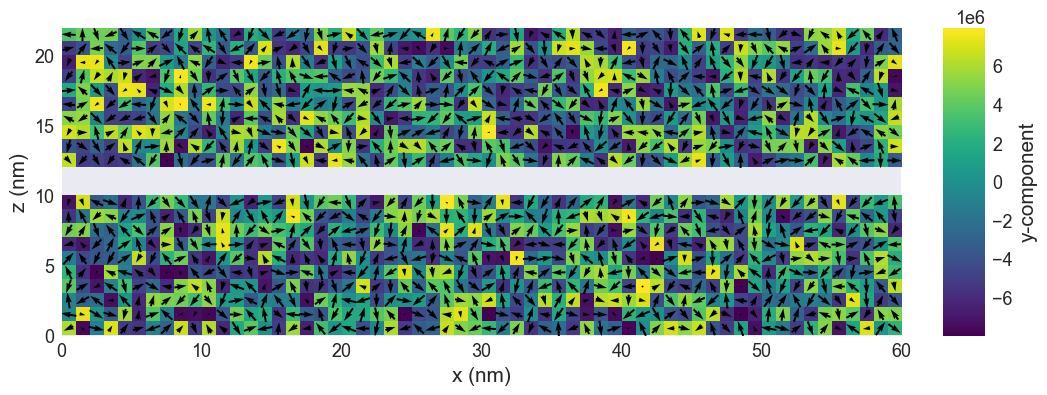

In [171]:
system.m.sel("y").mpl(figsize=(15,4))

In [172]:
system.energy += id

In [173]:
system.energy

RKKY(sigma=-10000.0, sigma2=0, subregions=['r1', 'r2']) + UniaxialAnisotropy(K={'r1': 100000.0, 'spacer': 0, 'r3': 100000.0}, u={'r1': (0, 0, 1), 'spacer': (0, 0, 0), 'r3': (0, 0, 0)}) + Zeeman(H={'r1': (0, 0, 1000000.0), 'spacer': (0, 0, 0), 'r3': (0, 0, 1000000.0)}) + idmi(D=(np.float64(1.0), 0, np.float64(6.123233995736766e-17)), m1=Field(Mesh(Region(pmin=[0.0, 0.0, 0.0], pmax=[6e-08, 6e-08, 1e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[60, 60, 10]), nvdim=3, vdims: (x, y, z)), m2=Field(Mesh(Region(pmin=[0.0, 0.0, 1.2e-08], pmax=[6e-08, 6e-08, 2.2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[60, 60, 10]), nvdim=3, vdims: (x, y, z)))

In [174]:
id

idmi(D=(np.float64(1.0), 0, np.float64(6.123233995736766e-17)), m1=Field(Mesh(Region(pmin=[0.0, 0.0, 0.0], pmax=[6e-08, 6e-08, 1e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[60, 60, 10]), nvdim=3, vdims: (x, y, z)), m2=Field(Mesh(Region(pmin=[0.0, 0.0, 1.2e-08], pmax=[6e-08, 6e-08, 2.2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[60, 60, 10]), nvdim=3, vdims: (x, y, z)))

In [175]:
md = oc.MinDriver()
md.drive(system)

KeyError: 'idmi_script'